# Medicaid Generosity by State

When evaluating the likelihood of Medicaid receipt, one must consider that the program rules change meaningfully across states.  It is, therefore, important to accomodate cross-state heterogeneity in any specification to be estimated.  However, the inclusion of 50 state dummies creates a great deal of sparsity, which taxes the numerical capacity of optimization routines.  A more continuous optimization surface can improve the stability and efficiency of the estimation process.

It would be ideal to have a single measure that captures the multi-dimensional concept of program generosity for each state.  Gathering and synthesizing the program rules across all states, however, is very labor intensive.  When this must be done for a period exceeding 30 years, the labor costs are likely to exceed the efficiency benefits.  A well-conceive proxy, on the other hand, might provide most of the benefit at a fraction of the cost.

When we think about the drivers of Medicaid benefit pursuit, there are two basic components:

1. *Ease of Access* - the eligibility tests for Medicaid dictate the benefit supply by constraining the sub-population that can receive the benefits to begin with.
2. *Benefit Value* - the size of the benefit itself dictates recipient demand, insofar as it is the utility attached to the transfer that induces participation from recipients.

We have little ability to efficiently capture the supply side element in a reasonable time period.  Indeed, it is not even clear that the rules for all states are feasibly available as far back as 1980.  We do have some potential for the construction of a proxy on the demand side.  Ideally, we would use the benefits per enrollee, but those data only go back until 1998 (the advent of electronic data storage in the Medicaid program).  A weaker alternative would be to capture the Medicaid expenditure per impoverished person.  We can get the Medicaid expenditure for each state from [NIPA regional accounts](http://www.bea.gov/iTable/index_regional.cfm), and [poverty data from the Census](https://www.census.gov/hhes/www/poverty/data/historical/people.html).  

We have already processed poverty data in **`pov_hist_state_1980_2014`**, but the NIPA data is a bit more involved.  The reason is the Medicaid figure tables are too large to download for several years at a time, and even then it would require a lot of post hoc manual cleaning.  This right here is why APIs exist.

In this Notebook, we will use the BEA API to capture Medicaid expenditure back to 1980.  We will then construct an output set that contains Medicaid expenditure per impoverished person by state and year (1980-2014).

In [42]:
#Data Management
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
from scipy import stats

#API Tools
import requests
import time

#Visualization
import seaborn as sb

%pylab inline

plt.rcParams['axes.edgecolor']='k'
plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.facecolor']=(1,1,1,0)
plt.rcParams['grid.color']='k'
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.linewidth']=0.3

Populating the interactive namespace from numpy and matplotlib


## Data Acquisition

The first task is to see that our API is working, and inspect the variables we have at our disposal.  The data structure is hierarchical, and in this case, our data is housed in a table.  We already know we are looking for information contained in the regional income accounts, so the first step is looking at the tables we can access within said accounts.  Specifically, we want to check the transfer related tables

In [3]:
#Capture the API key
key='027446AC-F203-4834-BF78-6E41378DAF42'

#Request table list via BEA API
table_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetParameterValues&'+\
                        'datasetname=RegionalIncome&ParameterName=TableName')

#For each table in the request...
for tbl in table_list.json()['BEAAPI']['Results']['ParamValue']:
    #...if the table contains state level transfer info...
    if 'transfer' in tbl['Desc'].lower():
        #...report back
        print tbl

{u'Key': u'CA35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [A]'}
{u'Key': u'SA35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [A]'}
{u'Key': u'SQ35', u'Desc': u'Personal Current Transfer Receipts (Non-Industry) [Q]'}


We have three options: `CA35, SA35, & SQ35`.  The first letter in each table name speaks to geography. `C` indicates county (or generally local), while `S` indicates state.  The second letter speaks to frequency of observation. `A` indicates annual, while `Q` indicates quarterly.  We want annual state level values, so `SA35` is our table.

There are, of course, many values contained in this table.  We only want Medicaid expenditures.  To pull the actual data, we need to know which line number corresponds to Medicaid in the `SA35` table.

In [4]:
#Request line number list via BEA API
line_no_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetParameterValuesFiltered&'+\
                          'datasetname=RegionalIncome&TargetParameter=LineCode&TableName=SA35')

#For each variable in the table...
for ln in line_no_list.json()['BEAAPI']['Results']['ParamValue']:
    #...if the table contains state level transfer info...
    if 'medicaid' in ln['Desc'].lower():
        #...report back
        print ln


{u'Key': u'2221', u'Desc': u'[SA35] Medicaid'}


Medicaid data is stored at the position demarcated by line number `2221` in the `SA35` table.  We can now pull the entire set of values for all years and states between 1980 and 2014.  To pull multiple years, we just need to provide a comma-delimited list for the `Year` parameter.

In [5]:
#Generate list of years
years=','.join([str(val) for val in range(1980,2015)])

#Request data
data_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetData&'+\
                       'datasetname=RegionalIncome&TableName=SA35&GeoFIPS=STATE&LineCode=2221&Year='+years)

#Capture data component of JSON object
data_json=data_list.json()['BEAAPI']['Results']['Data']

data_json[0]

{u'CL_UNIT': u'thousands of dollars',
 u'Code': u'SA35-2221',
 u'DataValue': u'487380000',
 u'GeoFips': u'00000',
 u'GeoName': u'United States',
 u'TimePeriod': u'2014',
 u'UNIT_MULT': u'3'}

Now, we have a list of JSON components, which for our purposes are dictionaries.  It is a simple matter convert each of them into a single line DataFrame.

In [6]:
DataFrame(data_json[100],index=[100])

,CL_UNIT,Code,DataValue,GeoFips,GeoName,TimePeriod,UNIT_MULT
100,thousands of dollars,SA35-2221,21275988,12000,Florida,2014,3


We can concatenate them together for a single set.

In [7]:
#Create container to hold each data row
data_rows=[]

#For each data row...
for i in range(len(data_json)):
    #...capture the row...
    tmp_row=DataFrame(data_json[i],index=[i])
    #...and throw it in data_rows
    data_rows.append(tmp_row)
    
#Concatenate into single DF
data=pd.concat(data_rows)

data

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
0,thousands of dollars,SA35-2221,487380000,00000,United States,NaN,2014,3
1,thousands of dollars,SA35-2221,439719000,00000,United States,NaN,2013,3
2,thousands of dollars,SA35-2221,369248000,00000,United States,NaN,2009,3
3,thousands of dollars,SA35-2221,396633000,00000,United States,NaN,2010,3
4,thousands of dollars,SA35-2221,405674000,00000,United States,NaN,2011,3
5,thousands of dollars,SA35-2221,417275000,00000,United States,NaN,2012,3
6,thousands of dollars,SA35-2221,304413000,00000,United States,NaN,2005,3
7,thousands of dollars,SA35-2221,299104000,00000,United States,NaN,2006,3
8,thousands of dollars,SA35-2221,324178000,00000,United States,NaN,2007,3
9,thousands of dollars,SA35-2221,338322000,00000,United States,NaN,2008,3


In [8]:
data.TimePeriod.value_counts()

2012    60
2013    60
2010    60
2011    60
2009    60
2008    60
2014    60
2005    60
2007    60
2006    60
Name: TimePeriod, dtype: int64

Not going to lie, I was a little alarmed when I saw the data stop at 2005.  However, spot checking does ensure that the data are available back to 1980.  It would appear that there is a limit on volume of data that may be pulled at one time.  This is not uncommon - it enables management of demand from their side.  The solution here is to build up subsets like the one above, and just insert a wait period after each one of a couple seconds.  This is most easily achieved in a function.  We will do this in five year increments.

In [9]:
def data_sub_request(years):
    #Request data
    data_list=requests.get('http://www.bea.gov/api/data?&UserID='+key+'=&method=GetData&'+\
                           'datasetname=RegionalIncome&TableName=SA35&GeoFIPS=STATE&LineCode=2221&Year='+years)

    #Capture data component of JSON object
    data_json=data_list.json()['BEAAPI']['Results']['Data']

    #Create container to hold each data row
    data_rows=[]

    #For each data row...
    for i in range(len(data_json)):
        #...capture the row...
        tmp_row=DataFrame(data_json[i],index=[i])
        #...and throw it in data_rows
        data_rows.append(tmp_row)

    #Concatenate into single DF
    data=pd.concat(data_rows)

    return data

#Create container for data subsets
data_subs=[]

#Create a container to hold of 5-year subsets
year_subs=[]

#For each starting year...
for start_yr in range(1980,2015,5):
    #...capture the five year increment
    year_subs.append(','.join([str(val) for val in range(start_yr,start_yr+5)]))
    
#For each year subset...
for yrsub in year_subs:
    print 'Capturing data for '+yrsub
    #...capture the data subset...
    data_tmp=data_sub_request(yrsub)
    #...throw it in data_subs...
    data_subs.append(data_tmp)
    #...and wait a bit before getting the next subset
    print '>> Sleeping...'
    time.sleep(3)
    
#Concatenate data subset together
data=pd.concat(data_subs)

data.TimePeriod.value_counts()

Capturing data for 1980,1981,1982,1983,1984
>> Sleeping...
Capturing data for 1985,1986,1987,1988,1989
>> Sleeping...
Capturing data for 1990,1991,1992,1993,1994
>> Sleeping...
Capturing data for 1995,1996,1997,1998,1999
>> Sleeping...
Capturing data for 2000,2001,2002,2003,2004
>> Sleeping...
Capturing data for 2005,2006,2007,2008,2009
>> Sleeping...
Capturing data for 2010,2011,2012,2013,2014
>> Sleeping...


2009    60
1988    60
2012    60
2013    60
2010    60
2011    60
2014    60
1989    60
1981    60
1990    60
1980    60
1983    60
1982    60
1985    60
1984    60
1987    60
1991    60
1993    60
2008    60
2003    60
2005    60
2004    60
2007    60
2006    60
2001    60
2000    60
2002    60
1992    60
1998    60
1999    60
1996    60
1997    60
1994    60
1995    60
1986    60
Name: TimePeriod, dtype: int64

That's more like it.  As can be seen, all of these data have come through as strings.

In [10]:
data.describe()

,CL_UNIT,Code,DataValue,GeoFips,GeoName,NoteRef,TimePeriod,UNIT_MULT
count,2100,2100,2100,2100,2100,70,2100,2100
unique,1,1,2099,60,60,1,35,1
top,thousands of dollars,SA35-2221,0,93000,Maine,*,2009,3
freq,2100,2100,2,35,35,70,60,2100


We also don't need all of it.  We should take note that all values are in $Th, and retain the following:  year, state, and value.

In [11]:
#Subset to the relevant variables
data2=data[['TimePeriod','GeoName','DataValue']]

#Convert to new column names
data2.columns=['year','state','mcaid_exp']

#Convert numeric columns
data2['year']=data2['year'].astype(int)
data2['mcaid_exp']=data2['mcaid_exp'].astype(float)

#Set index
data2.set_index(['state','year'],inplace=True)

#Sort index
data2.sortlevel(0,inplace=True)

data2.head(10)

C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\frame.py:3251: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

mcaid_exp
state   year           
Alabama 1980     292520
        1981     280381
        1982     350431
        1983     361170
        1984     383259
        1985     448813
        1986     427865
        1987     437244
        1988     481940
        1989     595991

## Medicaid Expenditure Normalized by Impoverished Population

We are now in a position to build our demand side proxy measure for Medicaid generosity.  Let's read in the poverty data.

In [23]:
#Read in data
pov=pd.read_csv('pov_by_state_1980_2014.csv')
 
#Set index
pov.set_index(['state','year'],inplace=True)

pov.head(10)

pop  num_pov  st_err_num  pct_pov  st_err_pct  st
state   year                                                    
Alabama 1980  3831      810          80     21.2        1.90  AL
        1981  3878      935          86     24.1        1.90  AL
        1982  3937      849          82     21.6        1.80  AL
        1983  3950      909          89     23.0        1.98  AL
        1984  3875      738          76     19.1        1.80  AL
        1985  3981      821          82     20.6        2.10  AL
        1986  4025      959          87     23.8        2.20  AL
        1987  3989      851          86     21.3        2.20  AL
        1988  4015      775          83     19.3        2.10  AL
        1989  4074      770          83     18.9        2.00  AL

In [24]:
print pov.to_string()

                                    pop      num_pov  st_err_num    pct_pov  st_err_pct  st
state                year                                                                  
Alabama              1980   3831.000000   810.000000   80.000000  21.200000    1.900000  AL
                     1981   3878.000000   935.000000   86.000000  24.100000    1.900000  AL
                     1982   3937.000000   849.000000   82.000000  21.600000    1.800000  AL
                     1983   3950.000000   909.000000   89.000000  23.000000    1.980000  AL
                     1984   3875.000000   738.000000   76.000000  19.100000    1.800000  AL
                     1985   3981.000000   821.000000   82.000000  20.600000    2.100000  AL
                     1986   4025.000000   959.000000   87.000000  23.800000    2.200000  AL
                     1987   3989.000000   851.000000   86.000000  21.300000    2.200000  AL
                     1988   4015.000000   775.000000   83.000000  19.300000    2

We will simply join the Medicaid expenditure info to the poverty data, which has all the state-year intersections we care about.  We can then capture Medicaid dollars per impoverished person.  *Note that the Medicaid dollars and impoverished population count are both in 000s.*

In [20]:
print data2.to_string()

                           mcaid_exp
state                year           
Alabama              1980     292520
                     1981     280381
                     1982     350431
                     1983     361170
                     1984     383259
                     1985     448813
                     1986     427865
                     1987     437244
                     1988     481940
                     1989     595991
                     1990     957851
                     1991    1171986
                     1992    1572324
                     1993    1634815
                     1994    1796077
                     1995    2005147
                     1996    2084545
                     1997    2258422
                     1998    2314545
                     1999    2450862
                     2000    2785083
                     2001    2947044
                     2002    3178764
                     2003    3502114
                     2004    3723046
 

In [25]:
#Integrate Medicaid data
pov['mcaid_exp']=data2['mcaid_exp'].ix[pov.index]

#Calculate Medicaid per impoverished person
pov['mcaid_ip']=pov['mcaid_exp']/pov['num_pov']

pov.head(20)

pop  num_pov  st_err_num  pct_pov  st_err_pct  st  mcaid_exp  \
state   year                                                                  
Alabama 1980  3831      810          80     21.2        1.90  AL     292520   
        1981  3878      935          86     24.1        1.90  AL     280381   
        1982  3937      849          82     21.6        1.80  AL     350431   
        1983  3950      909          89     23.0        1.98  AL     361170   
        1984  3875      738          76     19.1        1.80  AL     383259   
        1985  3981      821          82     20.6        2.10  AL     448813   
        1986  4025      959          87     23.8        2.20  AL     427865   
        1987  3989      851          86     21.3        2.20  AL     437244   
        1988  4015      775          83     19.3        2.10  AL     481940   
        1989  4074      770          83     18.9        2.00  AL     595991   
        1990  4063      779          83     19.2        2.00  AL     957851   
        1991  4178      786          83     18.8        2.00  AL    1171986   
        1992  4226      729          81     17.3        1.92  AL    1572324   
        1993  4168      725          81     17.4        1.94  AL    1634815   
        1994  4299      704          80     16.4        1.87  AL    1796077   
        1995  4396      882          86     20.1        1.96  AL    2005147   
        1996  4258      595          79     14.0        1.72  AL    2084545   
        1997  4243      665          83     15.7        1.81  AL    2258422   
        1998  4190      609          80     14.5        1.76  AL    2314545   
        1999  4388      668          84     15.2        1.76  AL    2450862   

                 mcaid_ip  
state   year               
Alabama 1980   361.135802  
        1981   299.872727  
        1982   412.757362  
        1983   397.326733  
        1984   519.321138  
        1985   546.666261  
        1986   446.157456  
        1987   513.800235  
        1988   621.858065  
        1989   774.014286  
        1990  1229.590501  
        1991  1491.076336  
        1992  2156.823045  
        1993  2254.917241  
        1994  2551.245739  
        1995  2273.409297  
        1996  3503.436975  
        1997  3396.123308  
        1998  3800.566502  
        1999  3668.955090

Keeping in mind our numerator is in nominal dollars, how does the state distribution of this ratio vary across time?

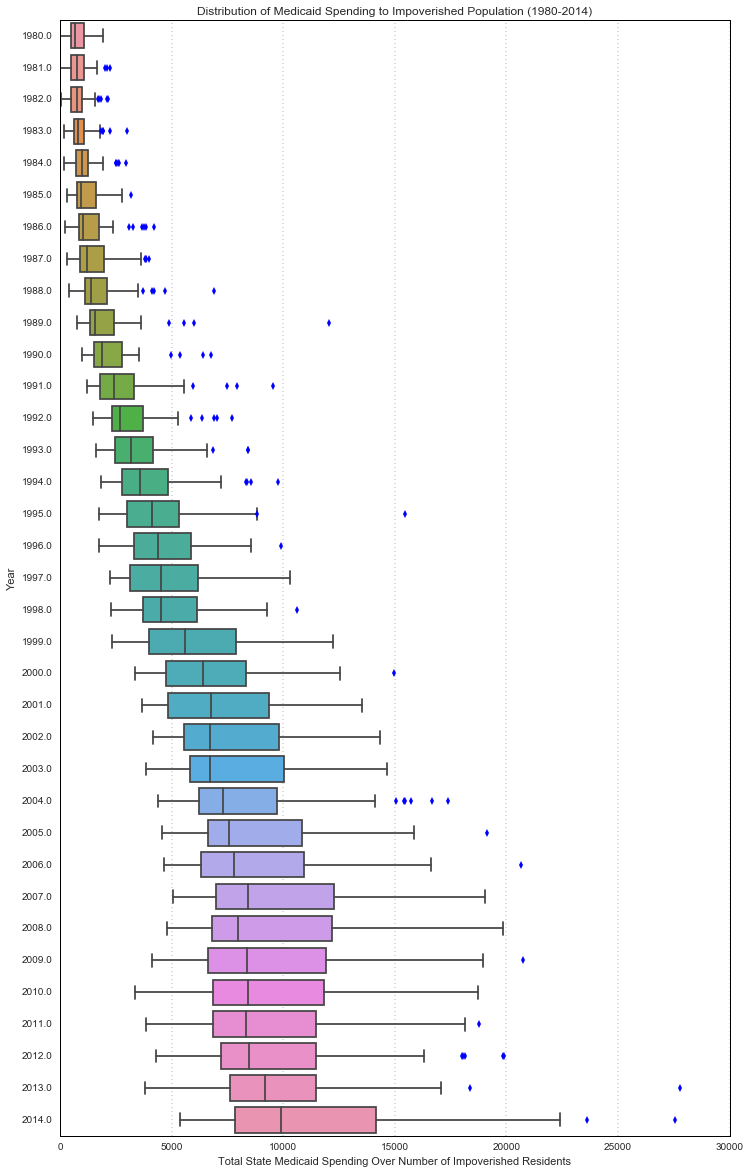

In [26]:
#Generate plot object
fig,ax=plt.subplots(figsize=(12,20))

#Generate box plot
sb.boxplot(x='mcaid_ip',y='year',data=pov.reset_index(),ax=ax,orient='h')

#Fix labels
ax.set_title('Distribution of Medicaid Spending to Impoverished Population (1980-2014)')
ax.set_xlabel('Total State Medicaid Spending Over Number of Impoverished Residents')
ax.set_ylabel('Year');

What's happening with the folks receiving over $15k a year?  That seems high.

In [27]:
pov[pov['mcaid_ip']>15000]

pop      num_pov  st_err_num    pct_pov  \
state                year                                                     
Alaska               2004    648.000000    59.000000    7.000000   9.100000   
                     2005    657.000000    66.000000    7.000000  10.000000   
                     2006    658.000000    58.000000    7.000000   8.900000   
                     2007    675.000000    51.000000    7.000000   7.600000   
                     2008    672.000000    55.000000    7.000000   8.200000   
                     2011    712.000000    83.000000    9.000000  11.700000   
                     2012    701.772828    70.061416    8.036155   9.983489   
                     2013    695.949329    76.160779   11.967625  10.943437   
                     2014    694.000000    82.000000    8.000000  11.853000   
Connecticut          2006   3457.000000   275.000000   34.000000   8.000000   
                     2008   3433.000000   276.000000   34.000000   8.100000   
                     2009   3472.000000   292.000000   35.000000   8.400000   
                     2010   3541.000000   303.000000   27.000000   8.600000   
                     2011   3514.000000   356.000000   33.000000  10.100000   
                     2012   3516.849604   362.721950   30.111726  10.313832   
                     2013   3544.966592   400.474035   35.973761  11.296976   
                     2014   3577.000000   308.000000   44.000000   8.605000   
Delaware             2014    929.000000   103.000000   10.000000  11.043000   
District of Columbia 2008    590.000000    98.000000    9.000000  16.500000   
                     2009    595.000000   107.000000    9.000000  17.900000   
                     2010    604.000000   118.000000    8.000000  19.500000   
                     2011    619.000000   123.000000    9.000000  19.900000   
                     2012    632.443830   116.401282    8.517091  18.404999   
                     2013    649.979933   138.707063   10.596193  21.340207   
                     2014    657.000000   125.000000    9.000000  19.024000   
Maine                2009   1297.000000   148.000000   16.000000  11.400000   
                     2013   1310.082713   160.500162   17.243761  12.251147   
Maryland             2014   5934.000000   584.000000   55.000000   9.850000   
Massachusetts        2004   6363.000000   594.000000   55.000000   9.300000   
                     2005   6318.000000   641.000000   57.000000  10.100000   
...                                 ...          ...         ...        ...   
New Hampshire        2004   1291.000000    71.000000   11.000000   5.500000   
                     2005   1298.000000    73.000000   11.000000   5.600000   
                     2006   1308.000000    71.000000   11.000000   5.400000   
                     2007   1312.000000    76.000000   11.000000   5.800000   
                     2010   1294.000000    84.000000    8.000000   6.500000   
                     2014   1318.000000    95.000000   11.000000   7.200000   
New York             2004  19010.000000  2847.000000  122.000000  15.000000   
                     2005  18995.000000  2760.000000  121.000000  14.500000   
                     2006  19021.000000  2668.000000  119.000000  14.000000   
                     2007  19021.000000  2757.000000  121.000000  14.500000   
                     2008  19309.000000  2734.000000  120.000000  14.200000   
                     2009  19158.000000  3018.000000  125.000000  15.800000   
                     2010  19116.000000  3062.000000  147.000000  16.000000   
                     2011  19329.000000  3085.000000  144.000000  16.000000   
                     2012  19297.532930  3328.035860  130.940777  17.245914   
                     2013  19487.810010  2825.319766  163.658322  14.497882   
                     2014  19658.000000  2755.000000  144.000000  14.017000   
Rhode Island         2007   1042.000000    99.000000   12.000000   9.500000   
       

Let's check this against some external sources.  First of all, how close are our NIPA values to other measures of Medicaid spending.  [KFF](http://kff.org/medicaid/state-indicator/total-medicaid-spending/#) has compiled some data by state for FY14.  Let's check proportional differences.

C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: order is deprecated, use sort_values(...)


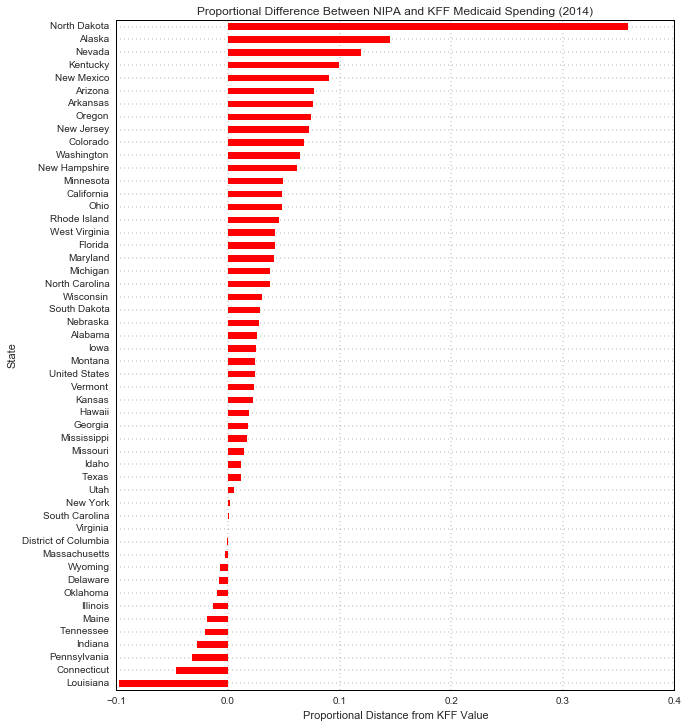

In [28]:
#Capture 2014 data from NIPA
data2014=data2['mcaid_exp'].xs(2014,level='year')

#Read in KFF data
kff_fy14=pd.read_csv('mcaid_kff_fy14.csv')

#Set index
kff_fy14.set_index('state',inplace=True)

#Join into single DF
mcaid_exp_compare=DataFrame(data2014).join(DataFrame(kff_fy14))

#Drop missing
mcaid_exp_compare=mcaid_exp_compare[mcaid_exp_compare['mcaid_kff'].notnull()]

#Convert KFF figures to $000s
mcaid_exp_compare['mcaid_kff']=mcaid_exp_compare['mcaid_kff']/1000.

#Capture difference
mcaid_exp_compare['diff']=mcaid_exp_compare['mcaid_exp']-mcaid_exp_compare['mcaid_kff']

#Capture proportion of KFF numbers
mcaid_exp_compare['diff_prop']=mcaid_exp_compare['diff']/mcaid_exp_compare['mcaid_kff']

#Generate plot object
fig,ax=plt.subplots(figsize=(10,12))

#Plot proportional difference
mcaid_exp_compare['diff_prop'].order().plot(kind='barh',ax=ax,color='r',lw=0)

#Fix labels
ax.set_title('Proportional Difference Between NIPA and KFF Medicaid Spending (2014)')
ax.set_xlabel('Proportional Distance from KFF Value')
ax.set_ylabel('State');

Some of these values are aggressively different.  The gaps are too large to be explained by FY-CY differences.  Curiously enough, the biggest gaps don't necessarily correspond to the most outrageous ratio values...

## CMS-64 Data

These NIPA data are little to wild and crazy for my liking.  For the years before 1997, we do not appear to have another data source available.  For the years after 1996, however, we have access to the expenditures reported by states to CMS.  These data are reported on form CMS-64.  They are, for reasons that escape me, stored in Excel files in a bizarre (but sufficiently regular) format.  **`medicaid_exp_cms`** has captured these data, written them to disk in a CSV file.  Specifically, we have captured total computable expenditures (which includes both the federal and state shares) for each state in the 1997-2011 period.  See **`medicaid_exp_cms`** for details on method and discretionary choices.

Since we are only concerned with the distributional position of state-level generosity *within year*, we are going to tolerate a discontinuity in the generosity proxy series between 1996 and 1997.  Throughout the entire series, the denominator will continue to be the impoverished population according to the Census.  Before 1997, the numerator will be state-level expenditures as reported in the NIPA data.  After 1996, the numerator will be state-level expenditures based upon the CMS-64 data.

Let us read in the data.

In [34]:
#Read in data
cms64=pd.read_csv('cms_64_by_st_97_11.csv')

#Replace DC abbreviation
cms64=cms64.replace('Dist. Of Col.','District of Columbia')

#Set index
cms64.set_index(['state','year'],inplace=True)

#Sort idnex
cms64.sortlevel(0,inplace=True)

cms64.head(10)

regular      admin
state   year                       
Alabama 1997  2195359746   46069028
        1998  2327239727   53658195
        1999  2456686168   79962881
        2000  2736969833   72112435
        2001  2928099085  112293202
        2002  3162601918  101262707
        2003  3567631847  127998912
        2004  3728343602  105702103
        2005  3938199110   87376814
        2006  3970886821  107790172

Now we can join it to the poverty data.

In [37]:
#Join to poverty data
pov['cms64']=cms64['regular'].ix[pov.index]/1000.

#Calculate Medicaid (CMS-64) per impoverished person
pov['mcaid_ip_cms64']=pov['cms64']/pov['num_pov']

pov

pop     num_pov  st_err_num    pct_pov  st_err_pct  st  \
state   year                                                                   
Alabama 1980  3831.000000  810.000000   80.000000  21.200000    1.900000  AL   
        1981  3878.000000  935.000000   86.000000  24.100000    1.900000  AL   
        1982  3937.000000  849.000000   82.000000  21.600000    1.800000  AL   
        1983  3950.000000  909.000000   89.000000  23.000000    1.980000  AL   
        1984  3875.000000  738.000000   76.000000  19.100000    1.800000  AL   
        1985  3981.000000  821.000000   82.000000  20.600000    2.100000  AL   
        1986  4025.000000  959.000000   87.000000  23.800000    2.200000  AL   
        1987  3989.000000  851.000000   86.000000  21.300000    2.200000  AL   
        1988  4015.000000  775.000000   83.000000  19.300000    2.100000  AL   
        1989  4074.000000  770.000000   83.000000  18.900000    2.000000  AL   
        1990  4063.000000  779.000000   83.000000  19.200000    2.000000  AL   
        1991  4178.000000  786.000000   83.000000  18.800000    2.000000  AL   
        1992  4226.000000  729.000000   81.000000  17.300000    1.920000  AL   
        1993  4168.000000  725.000000   81.000000  17.400000    1.940000  AL   
        1994  4299.000000  704.000000   80.000000  16.400000    1.870000  AL   
        1995  4396.000000  882.000000   86.000000  20.100000    1.960000  AL   
        1996  4258.000000  595.000000   79.000000  14.000000    1.720000  AL   
        1997  4243.000000  665.000000   83.000000  15.700000    1.810000  AL   
        1998  4190.000000  609.000000   80.000000  14.500000    1.760000  AL   
        1999  4388.000000  668.000000   84.000000  15.200000    1.760000  AL   
        2000  4376.000000  583.000000   53.000000  13.300000    1.120000  AL   
        2001  4378.000000  696.000000   57.000000  15.900000    1.210000  AL   
        2002  4432.000000  640.000000   55.000000  14.500000    1.150000  AL   
        2003  4417.000000  663.000000   56.000000  15.000000    1.170000  AL   
        2004  4508.000000  762.000000   59.000000  16.900000    1.310000  AL   
        2005  4501.000000  750.000000   59.000000  16.700000    1.310000  AL   
        2006  4532.000000  650.000000   56.000000  14.300000    1.230000  AL   
        2007  4566.000000  662.000000   56.000000  14.500000    1.230000  AL   
        2008  4716.000000  675.000000   57.000000  14.300000    1.200000  AL   
        2009  4655.000000  770.000000   60.000000  16.600000    1.280000  AL   
...                   ...         ...         ...        ...         ...  ..   
Wyoming 1985   506.000000   61.000000    9.000000  12.000000    1.800000  WY   
        1986   496.000000   73.000000   10.000000  14.600000    2.000000  WY   
        1987   451.000000   49.000000    9.000000  10.800000    1.900000  WY   
        1988   454.000000   43.000000    8.000000   9.600000    1.800000  WY   
        1989   462.000000   50.000000    9.000000  10.900000    1.900000  WY   
        1990   463.000000   51.000000    9.000000  11.000000    1.900000  WY   
        1991   470.000000   47.000000    8.000000   9.900000    1.800000  WY   
        1992   475.000000   49.000000    9.000000  10.300000    1.820000  WY   
        1993   481.000000   64.000000   10.000000  13.300000    2.020000  WY   
        1994   485.000000   45.000000    8.000000   9.300000    1.730000  WY   
        1995   482.000000   59.000000    8.000000  12.200000    1.660000  WY   
        1996   486.000000   58.000000    8.000000  11.900000    1.640000  WY   
        1997   490.000000   66.000000    9.000000  13.500000    1.730000  WY   
        1998   484.000000   51.000000    8.000000  10.600000    1.560000  WY   
        1999   484.000000   56.000000    8.000000  11.600000    1.620000  WY   
        2000   485.000000   52.000000    5.000000  10.800000    1.020000  WY   
        2001   487.000000   42.000000    5.000000   8.700000    0.930000  WY   
        2002   488.000

Is there much difference between the two ratios between 1997 and 2011?

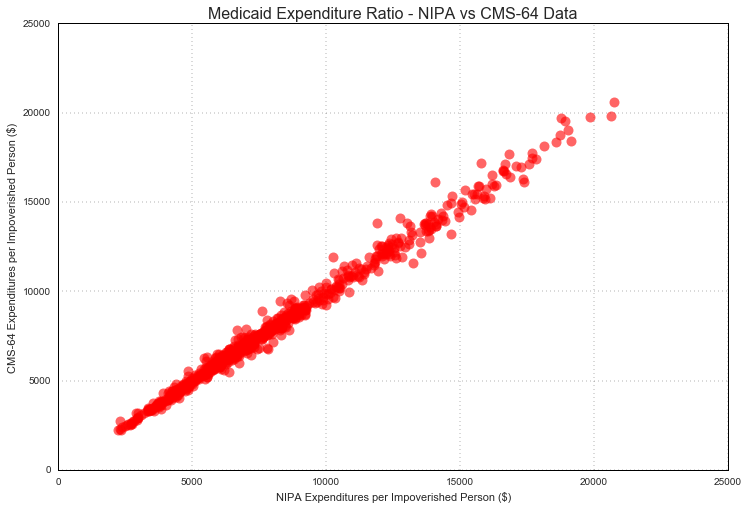

In [38]:
#Generate plot object
fig,ax=plt.subplots(figsize=(12,8))

#Plot regular vs admin
ax.scatter(pov['mcaid_ip'],pov['mcaid_ip_cms64'],s=100,alpha=.6,c='r',lw=0)

#Fix labels
ax.set_title('Medicaid Expenditure Ratio - NIPA vs CMS-64 Data',fontsize=16)
ax.set_xlabel('NIPA Expenditures per Impoverished Person ($)')
ax.set_ylabel('CMS-64 Expenditures per Impoverished Person ($)');

Hmmm.  There doesn't seem to much break in the relationship.  Maybe something is more apparent in the time series?

,20,40,50,60,80,100
1980,442.767245,578.834621,660.823529,763.832797,1087.444444,1944.640221
1981,477.908108,624.332577,742.823370,807.719128,1123.961993,2216.918919
1982,475.698690,664.981261,755.915081,875.979381,1053.728372,2134.346759
1983,545.556086,689.782520,800.725857,921.877551,1239.791063,3002.331828
1984,631.904255,783.295045,985.911047,1018.808899,1424.913043,2939.880539
1985,724.001848,824.624093,936.287037,1128.990741,1857.450079,3196.869048
1986,825.802817,917.579365,1047.944238,1230.177620,2017.083947,4224.831169
1987,839.373832,1101.550251,1191.530303,1549.616415,2318.380952,3966.000000
1988,1025.886364,1281.366337,1396.329825,1841.803957,2288.828358,6911.453125
1989,1228.608597,1441.644779,1551.297710,1667.048064,2717.666667,12050.133333


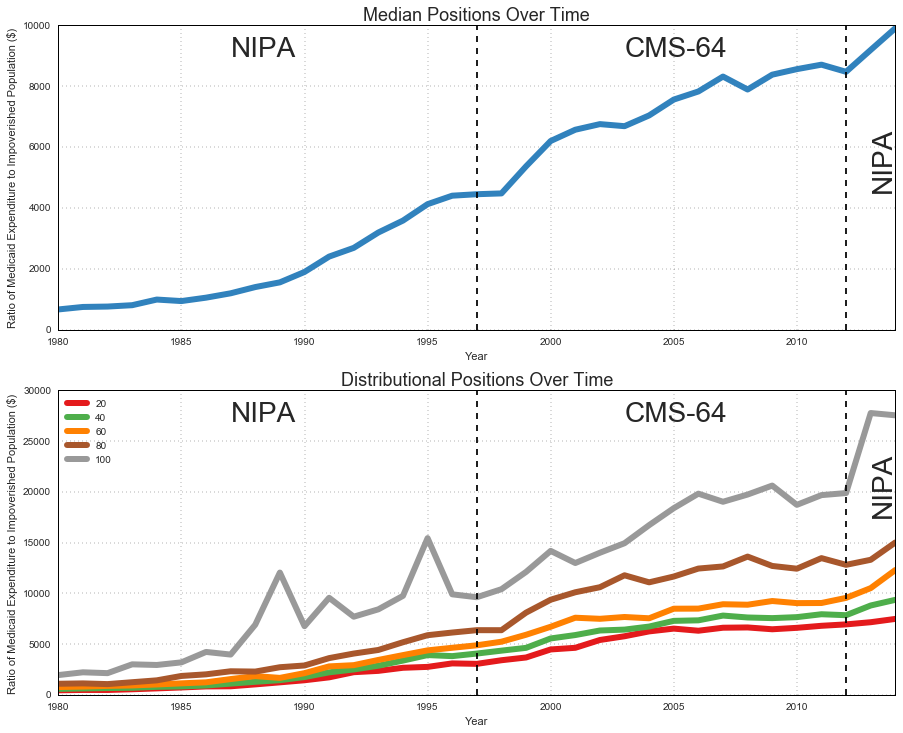

In [72]:
#Capture composite of NIPA and CMS-64 ratios
pov['mcaid_ip_comp']=np.where(pov['mcaid_ip_cms64'].notnull(),pov['mcaid_ip_cms64'],pov['mcaid_ip'])

#Isolate composite ratio
comp_rat=pov['mcaid_ip_comp'].swaplevel(0,1).sortlevel(0)

#Create a container to hold year subsets
yr_subs=[]

#For each year...
for yr in range(1980,2015):
    #...capture the year sub...
    yr_in=comp_rat.ix[yr]
    #...deposit values at each quintile into a new DF...
    yr_out=DataFrame({20:stats.scoreatpercentile(yr_in,20),
                      40:stats.scoreatpercentile(yr_in,40),
                      50:stats.scoreatpercentile(yr_in,50),
                      60:stats.scoreatpercentile(yr_in,60),
                      80:stats.scoreatpercentile(yr_in,80),
                      100:stats.scoreatpercentile(yr_in,100)},index=[yr])
    #...and throw it in yr_subs
    yr_subs.append(yr_out)
    
#Concatenate into a single DF
comp_rat_yr=pd.concat(yr_subs)

#Generate plot object
fig,ax=plt.subplots(2,figsize=(15,12))

#Plot the median of the composite ratio over time
comp_rat_yr[50].plot(kind='line',ax=ax[0],color='#3182bd',lw=6)

#Plot the distributional positions of the composite ratio over time
comp_rat_yr[[20,40,60,80,100]].plot(kind='line',ax=ax[1],colormap='Set1',lw=6)

#Include lines at 1997 and 2012
ax[0].axvline(x=1997,linestyle='--',c='k')
ax[0].axvline(x=2012,linestyle='--',c='k')
ax[0].annotate('NIPA',xy=(1987,9000),fontsize=28)
ax[0].annotate('CMS-64',xy=(2003,9000),fontsize=28)
ax[0].annotate('NIPA',xy=(2013,6000),fontsize=28,rotation=90)

ax[1].axvline(x=1997,linestyle='--',c='k')
ax[1].axvline(x=2012,linestyle='--',c='k')
ax[1].annotate('NIPA',xy=(1987,27000),fontsize=28)
ax[1].annotate('CMS-64',xy=(2003,27000),fontsize=28)
ax[1].annotate('NIPA',xy=(2013,22000),fontsize=28,rotation=90)

#Fix labels
ax[0].set_title('Median Positions Over Time',fontsize=18)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Ratio of Medicaid Expenditure to Impoverished Population ($)')

ax[1].set_title('Distributional Positions Over Time',fontsize=18)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Ratio of Medicaid Expenditure to Impoverished Population ($)')

comp_rat_yr

Well, there doesn't seem to be breaks clearly attributable to the new data source.  If anything, we could see slightly higher growth in median level during the CMS-64 period.  The volatility in ratio values, however, at least appears slightly reduced.

In the end, the CMS-64 directly corresponds to state reporting, so we will use it as the numerator where available (it only matters through 2011 anyway).  As for the denominator, the number of impoverished persons, Census is the best source for this information (which what we have used).

## Generosity as Distributional Position

Our final measure will not employ the direct ratio values, because we do not want to deal with nominal growth over time.  We will use a relative measure, percentile at value.  The output is simply a single series, indexed by year and state abbreviation, that holds the percentile value for each state ratio value within year.  

In [83]:
#Reset index
gen_out=pov.reset_index()[['year','st','mcaid_ip_comp']].set_index(['year','st'])

#Sort index
gen_out.sortlevel(0,inplace=True)

#Create container to hold year subset
yr_subs=[]

#For each year...
for yr in range(1980,2015):
    #...capture the subset...
    yr_sub=gen_out.ix[yr]
    #...calculate percentile values...
    yr_sub['gen_pos']=yr_sub['mcaid_ip_comp'].apply(lambda x: stats.percentileofscore(yr_sub['mcaid_ip_comp'].values,x))
    #...reintegrate year...
    yr_sub['year']=yr
    #...and throw the sub in yr_subs
    yr_subs.append(yr_sub.reset_index())
    
#Concatenate back together
gen_out=pd.concat(yr_subs)

#Set index
gen_out.set_index(['year','st'],inplace=True)

gen_out

mcaid_ip_comp     gen_pos
year st                           
1980 AK    1087.444444   80.392157
     AL     361.135802    9.803922
     AR     504.002066   33.333333
     AZ       0.000000    1.960784
     CA    1071.941199   74.509804
     CO     749.323887   58.823529
     CT    1284.670588   90.196078
     DC    1230.740458   88.235294
     DE     660.823529   50.980392
     FL     246.531324    3.921569
     GA     658.726272   49.019608
     HI    1134.777778   86.274510
     IA     763.832797   60.784314
     ID     361.710145   11.764706
     IL     921.738817   68.627451
     IN     589.026357   45.098039
     KS     888.455814   64.705882
     KY     448.074180   23.529412
     LA     488.926267   27.450980
     MA    1944.640221  100.000000
     MD    1100.455013   82.352941
     ME     892.367089   66.666667
     MI     984.910385   72.549020
     MN    1707.467836   94.117647
     MO     522.012800   37.254902
     MS     374.758037   13.725490
     MT     608.490196   47.058824
     NC     472.855188   25.490196
     ND     489.181818   29.411765
     NE     534.577889   39.215686
...                ...         ...
2014 ME   12688.952632   64.705882
     MI    9642.608755   47.058824
     MN   23597.800895   98.039216
     MO   14595.319355   78.431373
     MS    7595.362385   23.529412
     MT    9188.239669   37.254902
     NC    7480.537545   21.568627
     ND   12522.380282   62.745098
     NE    8451.457014   33.333333
     NH   15014.821053   80.392157
     NJ   13314.781836   72.549020
     NM   11233.729064   56.862745
     NV    5384.215481    1.960784
     NY   19708.835935   90.196078
     OH   11454.305804   58.823529
     OK    7600.122102   25.490196
     OR   12879.656140   66.666667
     PA   14455.059456   76.470588
     RI   21519.840336   94.117647
     SC    7055.611675   11.764706
     SD    7409.422018   17.647059
     TN    8083.596257   27.450980
     TX    7464.944775   19.607843
     UT    7066.426174   15.686275
     VA    9041.559382   35.294118
     VT   27548.771930  100.000000
     WA   12993.420188   68.627451
     WI   12300.662420   60.784314
     WV    9284.109043   39.215686
     WY    9888.109091   49.019608

[1785 rows x 2 columns]

In [84]:
gen_out['gen_pos'].describe()

count    1785.000000
mean       50.980392
std        28.870052
min         1.960784
25%        25.490196
50%        50.980392
75%        76.470588
max       100.000000
Name: gen_pos, dtype: float64

It looks like we are finally in a position to write to disk and take this baby to the other side.

In [88]:
DataFrame(gen_out['gen_pos']).to_csv('mcaid_generosity_by_st.csv')

In [89]:
!head -5 mcaid_generosity_by_st.csv

year,st,gen_pos
1980,AK,80.3921568627
1980,AL,9.80392156863
1980,AR,33.3333333333
1980,AZ,1.96078431373


In [87]:
gen_out['gen_pos'].ix[1980,'AK']

80.392156862745097